<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/Distribution_naissances_fashiondesigners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Distribution des naissances dans le temps et proportion des genres

Ce carnet présente une analyse de la distribution dans le temps des années de naissance de la population retenue ainsi que la mise en évidence de générations.

L'évolution dans le temps des genres présents dans la population est également présentée.

On tentera d'apporter des éléments de réponse aux questions suivantes?



*   Y'a-t-il des périodes où les effectifs de créateurs.trices de mode étaient plus/moins importants? Comment l'expliquer?
*   La propriété de genre des créateurs/créatrices de mode évolue-elle au fil du temps? (par exemple, y a-t-il plus de femmes créatrices de mode à un certain moment?)



In [1]:
!pip install sparqlwrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.0 MB/s eta 0:00:00


In [2]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_notebooks')
import sparql_functions as spqf

## Préparation des données et création d'un dataframe

### SPARQL Query qui récupère les données
On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [5]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [6]:
query = """
SELECT DISTINCT ?item ?itemLabel ?gender ?year
WHERE {
  {
    {?item wdt:P106 wd:Q3501317} # occupation is fashion designer.
        UNION
        {?item wdt:P101 wd:Q29583} # field of work is fashion design
     }
?item wdt:P31 wd:Q5; # Any instance of a human.
        wdt:P569 ?birthDate.
 ?item  wdt:P21 ?gender.
    BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
    FILTER(xsd:integer(?year) > 1800 && xsd:integer(?year) < 2001)

SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
ORDER BY ?year
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [8]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

3807


[['http://www.wikidata.org/entity/Q3524312',
  'Thierry Hermès',
  'http://www.wikidata.org/entity/Q6581097',
  '1801'],
 ['http://www.wikidata.org/entity/Q94834335',
  'Johann Kranzberger',
  'http://www.wikidata.org/entity/Q6581097',
  '1804'],
 ['http://www.wikidata.org/entity/Q62128099',
  'August Mannerheim',
  'http://www.wikidata.org/entity/Q6581097',
  '1805']]

In [9]:
### Créer un DataFrame à partir du résultat
df_r = pd.DataFrame(r)
df_r.columns = ['personUri', 'personLabel', 'genderUri', 'birthYear']
df_r.head()

,personUri,personLabel,genderUri,birthYear
0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801
1,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804
2,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805
3,http://www.wikidata.org/entity/Q4721481,Alexis Lavigne,http://www.wikidata.org/entity/Q6581097,1812
4,http://www.wikidata.org/entity/Q4962968,Carolina Lindström,http://www.wikidata.org/entity/Q6581072,1812


In [10]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3807 entries, 0 to 3806
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    3807 non-null   object
 1   personLabel  3807 non-null   object
 2   genderUri    3807 non-null   object
 3   birthYear    3807 non-null   object
dtypes: object(4)
memory usage: 119.1+ KB


###Se connecter à la base de données

In [11]:
# Chemin de la base de données dans Google Drive
db_path = "/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db"

# Connexion à la base de données SQLite
cn = sql.connect(db_path)
cn

In [12]:
### Tester une requête SQL sur une table existante
cur = cn.cursor()
l = cur.execute("SELECT * FROM person limit 3").fetchall()

In [13]:
[print(e) for e in l]

(1, 'Thierry Hermès', 1801, 'male', None, 'http://www.wikidata.org/entity/Q3524312')
(2, 'Johann Kranzberger', 1804, 'male', None, 'http://www.wikidata.org/entity/Q94834335')
(3, 'August Mannerheim', 1805, 'male', None, 'http://www.wikidata.org/entity/Q62128099')


[None, None, None]

In [14]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, alor qu'elle existe déjà,
# un message d'erreur est renvoyé
try:
    l = df_r.to_sql(name='wdt_personne', con=cn, if_exists='fail')
except Exception as e:
    print('Erreur: ',  e)

Erreur:  Table 'wdt_personne' already exists.


In [15]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_personne limit 3").fetchall()

In [16]:
### On a mis le résultat de la requête SQL
# dans une liste 'l' qu'on affiche avec une boucle 'for'
# dans le cadre d'une 'list comprehension'
a = [print(e) for e in l]

(0, 'http://www.wikidata.org/entity/Q3524312', 'Thierry Hermès', 'http://www.wikidata.org/entity/Q6581097', '1801')
(1, 'http://www.wikidata.org/entity/Q94834335', 'Johann Kranzberger', 'http://www.wikidata.org/entity/Q6581097', '1804')
(2, 'http://www.wikidata.org/entity/Q62128099', 'August Mannerheim', 'http://www.wikidata.org/entity/Q6581097', '1805')


### Créer un DataFrame contenant la table entière

In [17]:
### On récupère tout la table et on la met dans la list 'l'
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_personne").fetchall()

In [18]:
### On transforme la liste en DataFrame
df_p = pd.DataFrame(l, columns=['id', 'person_uri', 'person_label', 'genderUri', 'birthYear'],)
df_p.head()

,id,person_uri,person_label,genderUri,birthYear
0,0.0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801
1,1.0,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804
2,2.0,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805
3,3.0,http://www.wikidata.org/entity/Q4721481,Alexis Lavigne,http://www.wikidata.org/entity/Q6581097,1812
4,4.0,http://www.wikidata.org/entity/Q4962968,Carolina Lindström,http://www.wikidata.org/entity/Q6581072,1812


In [19]:
# problèmes car l'index s'affiche en float et pas en integer
# Extraire l'index actuel du DataFrame
index_values = df_p.index

# Remplacer la colonne 'id' par l'index
df_p['id'] = index_values


df_p = df_p.set_index('id',drop=True)

# Afficher les premières lignes du DataFrame pour vérifier les modifications
df_p.head()

,person_uri,person_label,genderUri,birthYear
id,,,,
0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801
1,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804
2,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805
3,http://www.wikidata.org/entity/Q4721481,Alexis Lavigne,http://www.wikidata.org/entity/Q6581097,1812
4,http://www.wikidata.org/entity/Q4962968,Carolina Lindström,http://www.wikidata.org/entity/Q6581072,1812


In [20]:
print(df_p.columns)

Index(['person_uri', 'person_label', 'genderUri', 'birthYear'], dtype='object')


### Vérifier les genres présents directement sur la base de données
La requête suivante sera exécutée directement sur la base de données.

Le résultat sera affiché dans le carnet Jupyter. On peut préparer les requêtes SQL directement dans un logiciel comme DBeaver, puis les exécuter depuis un carnet Jupyter pour récupérer le résultat


In [21]:
query = """
SELECT genderUri, count(*) as eff
FROM wdt_personne
GROUP BY genderUri
ORDER BY eff DESC"""

In [22]:
cur = cn.cursor()

In [23]:
res = cur.execute(query)

In [24]:
res.fetchall()

[(None, 2667),
 ('http://www.wikidata.org/entity/Q6581072', 2108),
 ('http://www.wikidata.org/entity/Q6581097', 1638),
 ('http://www.wikidata.org/entity/Q1052281', 11),
 ('http://www.wikidata.org/entity/Q48270', 5),
 ('http://www.wikidata.org/entity/Q18116794', 1),
 ('http://www.wikidata.org/entity/Q1289754', 1),
 ('http://www.wikidata.org/entity/Q121307100', 1)]

###Ajouter une colonne au DataFrame avec le code du genre

In [25]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a

In [26]:
### On teste la fonction
code_gender('http://www.wikidata.org/entity/Q48270')

'A'

In [27]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['genCode'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

In [28]:
print(df_p.columns)

Index(['person_uri', 'person_label', 'genderUri', 'birthYear', 'genCode'], dtype='object')


In [29]:
df_p.head()

,person_uri,person_label,genderUri,birthYear,genCode
id,,,,,
0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801,M
1,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804,M
2,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805,M
3,http://www.wikidata.org/entity/Q4721481,Alexis Lavigne,http://www.wikidata.org/entity/Q6581097,1812,M
4,http://www.wikidata.org/entity/Q4962968,Carolina Lindström,http://www.wikidata.org/entity/Q6581072,1812,F


In [30]:
# Étape 1: Filtrer les lignes où 'genCode' est 'A'
filtered_df = df_p[df_p['genCode'] == 'A']

# Étape 2: Sélectionner les trois premières lignes du DataFrame filtré
result = filtered_df[:3]

print(result)

                                     person_uri         person_label  \
id                                                                     
845     http://www.wikidata.org/entity/Q5297781         Dorian Corey   
1199    http://www.wikidata.org/entity/Q7166361       Pepper LaBeija   
1594  http://www.wikidata.org/entity/Q121887025  Robertina Manganaro   

                                    genderUri birthYear genCode  
id                                                               
845   http://www.wikidata.org/entity/Q1052281      1937       A  
1199  http://www.wikidata.org/entity/Q1052281      1948       A  
1594  http://www.wikidata.org/entity/Q1052281      1958       A  


In [31]:
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['genCode']=='A'][:3]

,person_uri,person_label,genderUri,birthYear,genCode
id,,,,,
845,http://www.wikidata.org/entity/Q5297781,Dorian Corey,http://www.wikidata.org/entity/Q1052281,1937,A
1199,http://www.wikidata.org/entity/Q7166361,Pepper LaBeija,http://www.wikidata.org/entity/Q1052281,1948,A
1594,http://www.wikidata.org/entity/Q121887025,Robertina Manganaro,http://www.wikidata.org/entity/Q1052281,1958,A


## Visualisation des effectifs par année de naissance

In [32]:
### On inspecte les valeurs de la colonne 'birthYear'
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
Index: 6432 entries, 0 to 6431
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
6432 non-null   object
dtypes: object(1)
memory usage: 100.5+ KB


In [33]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [34]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 200
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 2001].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1801,1
1,1804,1
2,1805,2
3,1812,2
4,1818,3
...,...,...
164,1996,29
165,1997,22
166,1998,18
167,1999,10


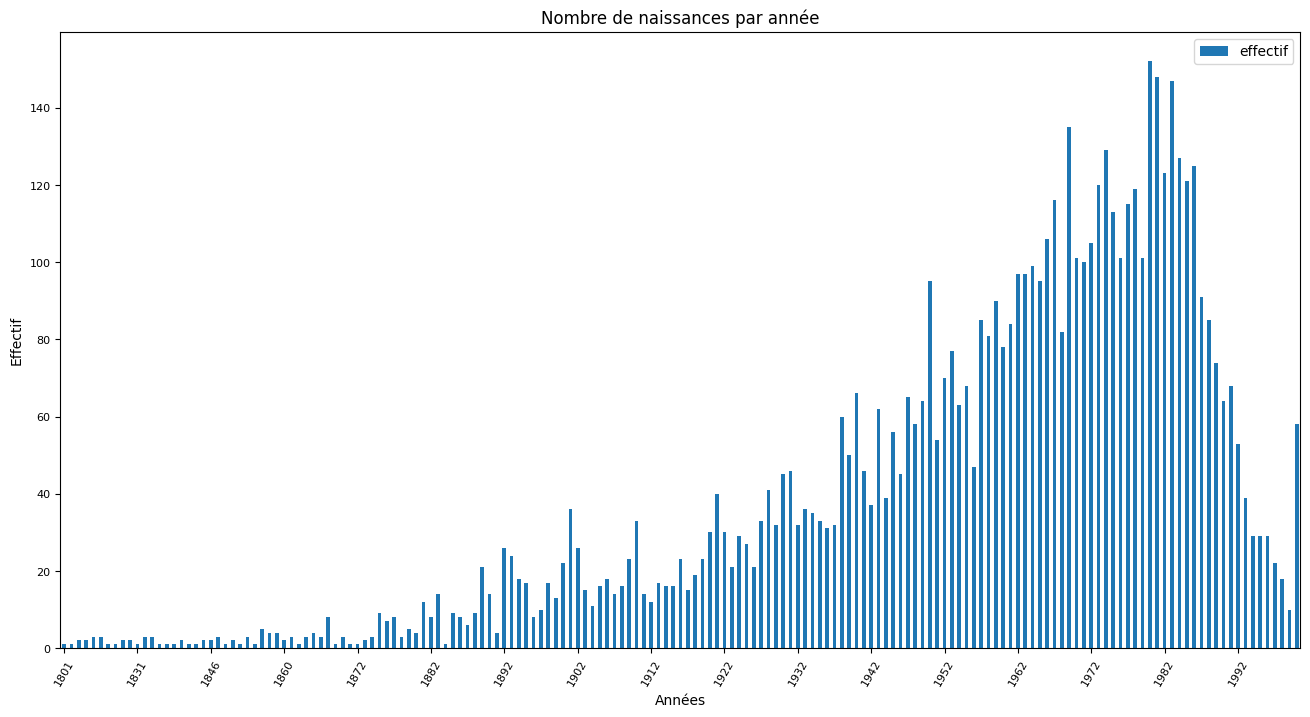

In [35]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

**Commentaire**

On remarque que les effectifs croissent globalement jusqu'à 1985, puis on observe un déclin très important, avec une remontée en 2000.

Il y'a donc eu moins de créateurs/trices de mode né.e.s entre 1985 et 2000. Peut-on l'expliquer par la conjoncture économique du début des années 2000 (crise des subprime) qui expliquerait une baisse dans les effectifs de cette profession certainement plus précaire et donc moins plebiscitée en temps de crise?



### Regrouper les effectifs par périodes de 25 ans

In [36]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias)
cdf_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [37]:
cdf_p.head(3)

,person_uri,person_label,genderUri,birthYear,genCode
id,,,,,
0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801,M
1,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804,M
2,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805,M


In [38]:
### Année minimale et maximale dans la population
min(cdf_p['birthYear']), max(cdf_p['birthYear'])

(1801, 2000)

## Visualisation des effectifs par génération (périodes de 25 ans)

In [39]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue,
# elle donc doit être supérieure à la valeur maximale
l_25 = list(range(1801, 2002, 25))
l_25[:5],l_25[-5:]

([1801, 1826, 1851, 1876, 1901], [1901, 1926, 1951, 1976, 2001])

In [40]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,person_uri,person_label,genderUri,birthYear,genCode,periodes
id,,,,,,
0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801,M,1801-1825
1,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804,M,1801-1825
2,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805,M,1801-1825


In [41]:
cdf_p[cdf_p.birthYear == 2000][:3]

,person_uri,person_label,genderUri,birthYear,genCode,periodes
id,,,,,,
3733,http://www.wikidata.org/entity/Q1569847,Hakan Yıldırım,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000
3734,http://www.wikidata.org/entity/Q1584914,Peggy Noland,http://www.wikidata.org/entity/Q6581072,2000,F,1976-2000
3735,http://www.wikidata.org/entity/Q1702004,John Varvatos,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000


In [42]:
### compter les naissances par périodes de 25 ans
cdf_p.groupby(by='periodes').size()

periodes
1801-1825      16
1826-1850      23
1851-1875      65
1876-1900     288
1901-1925     540
1926-1950    1160
1951-1975    2292
1976-2000    2048
dtype: int64

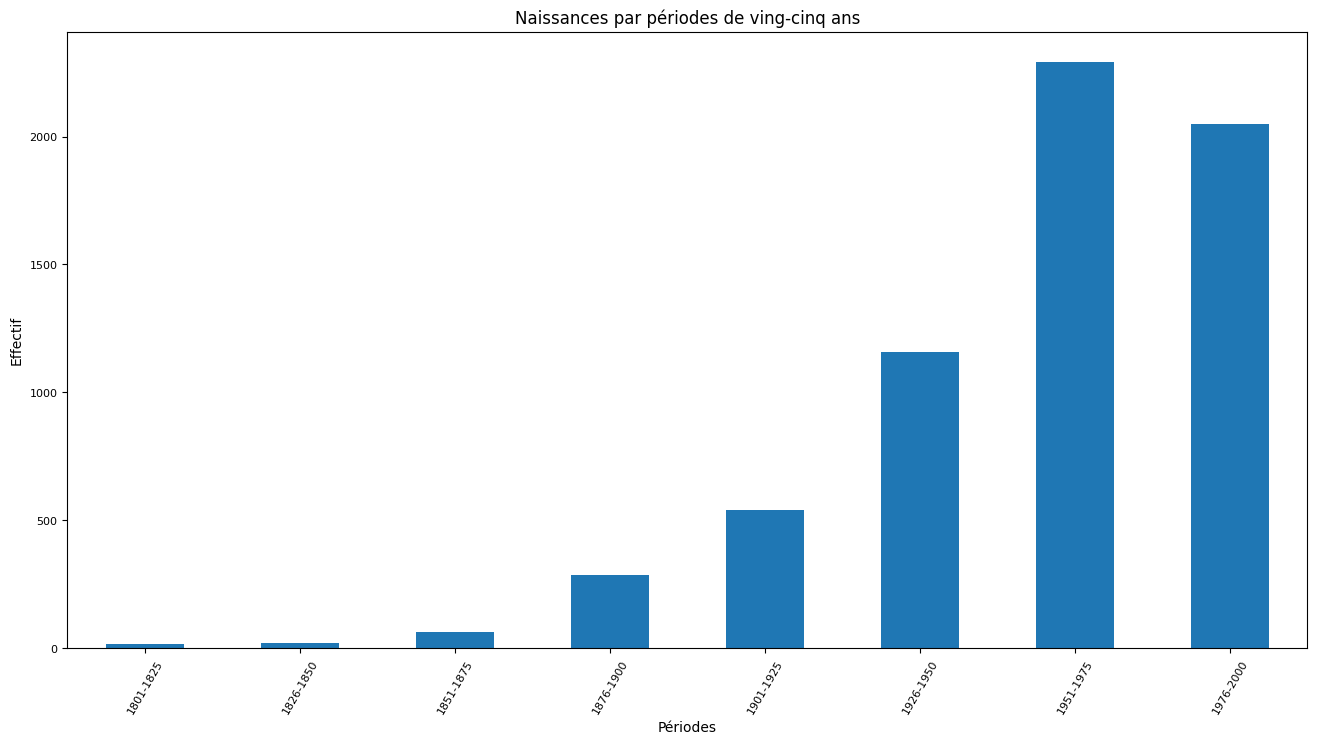

In [43]:
ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

### Ajouter la représentation des genres

In [44]:
### Regrouper et compter avec un fitre sur le genre masculin
gender_m = pd.DataFrame(cdf_p[cdf_p.genCode == 'M'].groupby('periodes').size())
gender_m.columns = ['gen_m']
gender_m.tail()


,gen_m
periodes,
1876-1900,56
1901-1925,133
1926-1950,342
1951-1975,633
1976-2000,451


In [45]:
### Regrouper et compter avec un fitre sur le genre féminin
gender_f = pd.DataFrame(cdf_p[cdf_p.genCode == 'F'].groupby('periodes').size())
gender_f.columns = ['gen_f']
gender_f.tail()


,gen_f
periodes,
1876-1900,116
1901-1925,218
1926-1950,344
1951-1975,690
1976-2000,685


In [46]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
merged = pd.merge(gender_m, gender_f, left_index=True, right_index=True)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,56,116
1901-1925,133,218
1926-1950,342,344
1951-1975,633,690
1976-2000,451,685


In [47]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,56,116
1901-1925,133,218
1926-1950,342,344
1951-1975,633,690
1976-2000,451,685


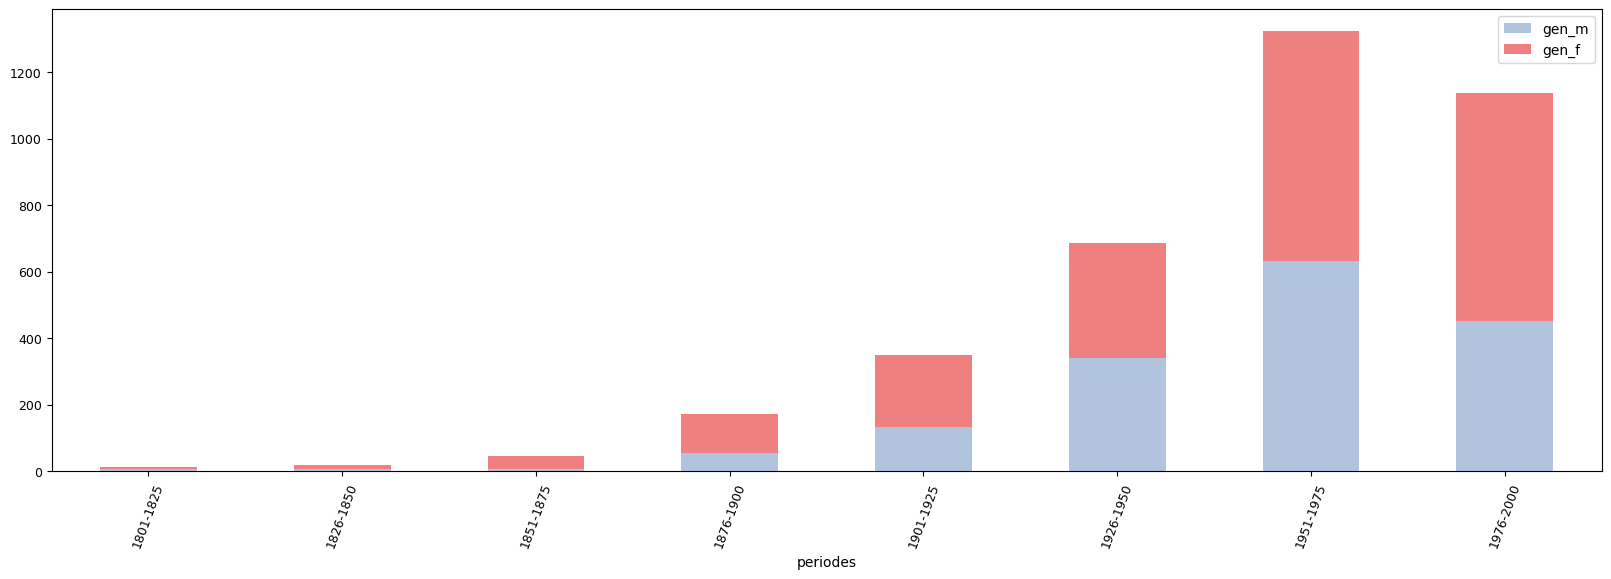

In [48]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['LightSteelBlue', 'LightCoral'])
plt.show()

### Codage par période de dix ans
Comme on voit bien dans le graphique précédent les effectifs de la période allant de 1801 à 1850 sont très faibles et peu significatifs.On restraint donc la période analysée aux années 1850-2000 et on affine avec un découpage par périodes de dix ans

In [49]:
l_10 = list(range(1851, 2002, 10))
l_10[:5],l_10[-5:]

([1851, 1861, 1871, 1881, 1891], [1961, 1971, 1981, 1991, 2001])

In [50]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_10'] = pd.cut(cdf_p['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_10'] = cdf_p['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,person_uri,person_label,genderUri,birthYear,genCode,periodes,per_10
id,,,,,,,
0,http://www.wikidata.org/entity/Q3524312,Thierry Hermès,http://www.wikidata.org/entity/Q6581097,1801,M,1801-1825,NaN
1,http://www.wikidata.org/entity/Q94834335,Johann Kranzberger,http://www.wikidata.org/entity/Q6581097,1804,M,1801-1825,NaN
2,http://www.wikidata.org/entity/Q62128099,August Mannerheim,http://www.wikidata.org/entity/Q6581097,1805,M,1801-1825,NaN


In [51]:
### On regroupe par genre comme ci-dessus
gender_m_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'M') & (cdf_p.birthYear > 1850)].groupby('per_10').size())
gender_m_10.columns = ['gen_m']
gender_m_10.tail()

,gen_m
per_10,
1951-1960,184
1961-1970,294
1971-1980,296
1981-1990,235
1991-2000,75


In [52]:
### Idem
gender_f_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'F')& (cdf_p.birthYear > 1850)].groupby('per_10').size())
gender_f_10.columns = ['gen_f']
gender_f_10.tail()


,gen_f
per_10,
1951-1960,219
1961-1970,292
1971-1980,371
1981-1990,384
1991-2000,109


In [53]:
merged_10 = pd.merge(gender_m_10, gender_f_10, left_index=True, right_index=True)
merged_10.tail()

,gen_m,gen_f
per_10,,
1951-1960,184,219
1961-1970,294,292
1971-1980,296,371
1981-1990,235,384
1991-2000,75,109


In [54]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['gen_m']+merged_10['gen_f']
merged_10.tail()

,gen_m,gen_f,tot
per_10,,,
1951-1960,184,219,403
1961-1970,294,292,586
1971-1980,296,371,667
1981-1990,235,384,619
1991-2000,75,109,184


## Visualisation des effectifs par période de dix ans avec fréquence du genre par période

In [55]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.gen_m.to_list()+merged_10.gen_f.to_list()

# liste d'égale longueur que la précédente qui contient
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[0.26, 0.05, 0.2]

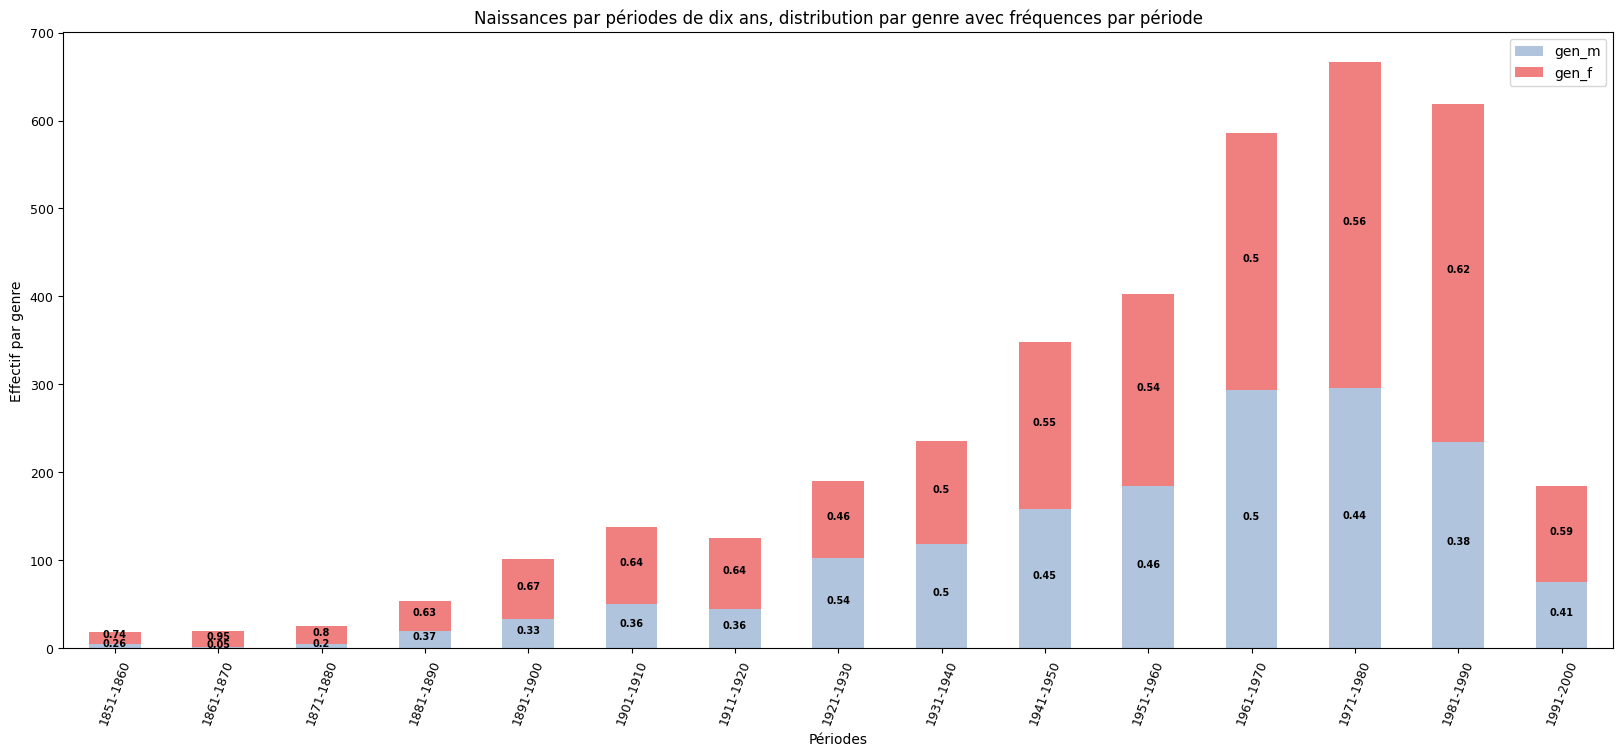

In [56]:
import os

# Votre code pour générer le graphique
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=['gen_m', 'gen_f'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp):

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,

      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(),

      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=7
  )

plt.ylabel('Effectif par genre')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de dix ans, distribution par genre avec fréquences par période')

# Créer le répertoire s'il n'existe pas déjà
directory = 'images'
if not os.path.exists(directory):
    os.makedirs(directory)

# Sauvegarder l'image dans le répertoire
plt.savefig('images/naissances_distribution_10ans_genre.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

**Commentaire**

En ce qui concerne la distribution de la fréquence des genres, on constate que les femmes ont toujours représenté plus de la moitié ou la moitié des effectifs.

Au 19e siècle, elles étaient majoritairement représentées, plus de 60%, puis au cours du 20e siècle, la fréquence relative varie entre 46% et 62%.

La création de vêtement était (en Occident dumoins) un des seuls domaines oû les femmes travaillaient, ces résultats ne sont pas réellement surprenants.
